<a href="https://colab.research.google.com/github/whitefreeze/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales_Part6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales
Project Revisited v2

## Imports & Data Prep 

### Import Necessary Libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics

## saving variables for next notebook
import joblib

from sklearn import set_config
set_config(display='diagram')

# display values with two decimal places and comma separation for powers of thousands.
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

### Functions

In [2]:
# Function from Regression Metrics Solutions code
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics for a model
def eval_regression(y_true, y_pred, name='mode'):
    """Takes true targets and predictions from a regression model and prints
    MAE, MSE, RMSE, AND R2 scores
    Set 'name' to name of model and 'train' or 'test' as appropriate"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f'{name} Scores')
    print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
       
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [4]:
def get_coeffs_linreg(linreg, feature_names = None, sort = True, ascending = True, name = 'LinearRegression Coefficients'):
        if feature_names is None:
            feature_names = linreg.feature_names_in_
            
        # Save coefficients
        coeffs = pd.Series(linreg.coef_, index = feature_names)
        coeffs['intercept'] = linreg.intercept_
        if sort == True: 
            coeffs = coeffs.sort_values(ascending = ascending)
        
        return coeffs

In [5]:
def plot_coeffs(coeffs, top_n = None, figsize = (4,5), intercept = False,
               intercept_name = 'intercept', annotate = False, ha = 'left', va = 'center',
               size = 12, xytext = (4,0), textcoords = 'offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations. """
    
    # Drop intercept if intercept = False
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
        
    if top_n == None:
        # Sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        # Rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending = False)
        top_n_features = coeff_rank.head(top_n)
        
        # Sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
        
    # Plotting top N importances
    ax = plot_vals.plot(kind = 'barh', figsize = figsize)
    ax.set(xlabel = 'Coefficient',
          ylabel = 'Feature Names',
          title = title)
    ax.axvline(0, color = 'k')
    
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    
    # return ax in case we want to continue to update/modify figure
    return ax

In [6]:
def annotate_hbars(ax, ha = 'left', va = 'center', size = 12, xytext = (4,0), textcoords = 'offset points'):
    for bar in ax.patches:
        
        # Calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        
        # Get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
            
        # ha & va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos, bar_ax), ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)

In [7]:
def plot_importance(importances, top_n = None, figsize = (8,6)):
    
    # Sorting with asc = false for correct order of bars
    if top_n == None:
        # Sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        # Sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
        
    # Plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel = 'Importance',
          ylabel = 'Feature Names',
          title = title)
    
    # Return ax in case we want to continue to update/modify figure
    return ax

In [8]:
def get_importances(model, feature_names = None, name = 'Feature Importance', sort = False, ascending = True):
    
    # Checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    # Saving the feature importances
    importances = pd.Series(model.feature_importances_, index=feature_names, name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

### Load the Data

In [9]:
# Connect Google Drive to import data
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# Import the data
path = 'Data/sales_predictions_2023.csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


In [11]:
# Explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


* Before splitting data, drop duplicates.

In [12]:
# Count number of duplicate rows in dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


-No duplicates found. None removed.

* Before splitting your data,
fix inconsistencies in categorical data.

In [13]:
# Check Item_Fat_Content for inconsistent categorical data.
df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [14]:
# Inconsistent observation naming found in feature. Combining observations as appropriate.
# replace 'LF' with 'Low Fat'
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
# replace 'low fat' with 'Low Fat'
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
# replace 'reg' with 'Regular'
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

In [15]:
df.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

-Item_Fat_Content obervations fixed.

-No other inconsistencies in categorical data found.

* Missing Values

In [16]:
# Display total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 3873 missing values.


In [17]:
# Display count of missing values by column
print(df.isna().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [18]:
# Display percentage of missing values by column
print(df.isna().sum()/len(df)*100)

Item_Identifier              0.00
Item_Weight                 17.17
Item_Fat_Content             0.00
Item_Visibility              0.00
Item_Type                    0.00
Item_MRP                     0.00
Outlet_Identifier            0.00
Outlet_Establishment_Year    0.00
Outlet_Size                 28.28
Outlet_Location_Type         0.00
Outlet_Type                  0.00
Item_Outlet_Sales            0.00
dtype: float64


-Two features have missing values: 
* Item_Weight
* Outlet_Size

We will use SimpleImputer in our preprocessing steps after performing our Train_Test_Split.

* Determine which features will be relevant to include in our features matrix.

In [19]:
# Display feature info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [20]:
# Count total number of observations.
print(f'Shape of data: {(df.shape)}\n')

# Only count unique values for categorical features: determine if relevant for feature matrix.
print(f"Item_Identifier: number of unique values = {df['Item_Identifier'].nunique()}")
print(f"Item_Fat_Content: number of unique values = {df['Item_Fat_Content'].nunique()}")
print(f"Item_Type: number of unique values = {df['Item_Type'].nunique()}")
print(f"Outlet_Size: number of unique values = {df['Outlet_Size'].nunique()}")
print(f"Outlet_Location_Type: number of unique values = {df['Outlet_Location_Type'].nunique()}")
print(f"Outlet_Type: number of unique values = {df['Outlet_Type'].nunique()}")

Shape of data: (8523, 12)

Item_Identifier: number of unique values = 1559
Item_Fat_Content: number of unique values = 2
Item_Type: number of unique values = 16
Outlet_Size: number of unique values = 3
Outlet_Location_Type: number of unique values = 3
Outlet_Type: number of unique values = 4


-While there are many unique values in Item_Identifier, this is reasonable as the same products are sold at different stores in our dataset and the column is not only made up of completely unique values; this means we should include the feature in our calculations.

### Ordinal Encoding

The ordinal data can be encoded without too much risk of data leakage, as there are only a few variables and are likely to be in both training and testing data. 

* Ordinal Encoding 

Outlet_Size is the only ordinal feature that we know the order of. Other features are ambiguious and will be treated as Nominal Categorical.

In [21]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [22]:
# Ordinal Encolding via .replace() as not able to get OrdinalEncoder working
replacement_dictionary = {'Small':0, 'Medium':1, 'High':2}
df['Outlet_Size'].replace(replacement_dictionary, inplace=True)
df['Outlet_Size']

0      1.00
1      1.00
2      1.00
3       NaN
4      2.00
       ... 
8518   2.00
8519    NaN
8520   0.00
8521   1.00
8522   0.00
Name: Outlet_Size, Length: 8523, dtype: float64

### Drop Unnecessary Columns

* Drop the 'Item_Identifier' column due to high cardinality

In [23]:
# Drop the 'Item_Identifier' column due to high cardinality
df.drop(columns=['Item_Identifier'], inplace=True)
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,1.00,Tier 1,Supermarket Type1,"3,735.14"
1,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,1.00,Tier 3,Supermarket Type2,443.42
2,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,1.00,Tier 1,Supermarket Type1,"2,097.27"
3,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,2.00,Tier 3,Supermarket Type1,994.71


### Split the Data

* Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.

In [24]:
# Define features (X) and target (y)
target = 'Item_Outlet_Sales'
X = df.drop(columns = [target]).copy()
y = df[target].copy()

* Perform a train test split

In [25]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Prepare the Data

* Identify the datatypes for each feature

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   float64
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 732.6+ KB


**Ordinal:** 'Outlet_Size'  (Outlet_Size has already been ordinal encoded.)

**Numeric:** 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment' 

**Nominal:** 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'

## Column Selectors, Tranformers & Pipelines

* Make sure your imputation of missing values occurs after the train test split using SimpleImputer. 

### ColumnSelector

As there is one ordinal categorical, must specify ordinal and nominal cateforical features manually.

In [27]:
# Instantiate column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

### Imputers

In [28]:
# Display total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 3873 missing values.


-We have many missing values and will require values to be imputed.

### Transformers & Drop Features

In [29]:
# Check string columns for the number of unique values
df.select_dtypes('object').nunique()

Item_Fat_Content         2
Item_Type               16
Outlet_Identifier       10
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In order to remove multicollinearity from our categorical features, we could use "drop = 'first'" for the OHE;  however, it will be better if we can select specific features to drop, particularly if it is a "leftover" category such as 'other'.

Specify which features to drop

In [30]:
# View list of categorical features
cat_selector(X)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Type']

In [31]:
# Loop over categorical features to view each unique value per feature

for col in cat_selector(X):
    print(F"For {col}: \n{X[col].unique()}\n")

For Item_Fat_Content: 
['Low Fat' 'Regular']

For Item_Type: 
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

For Outlet_Identifier: 
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

For Outlet_Location_Type: 
['Tier 1' 'Tier 3' 'Tier 2']

For Outlet_Type: 
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [32]:
# Drop most ambiguous values in each feature (i.e. - 'other')

drop_categories = ['Regular', 'Others', 'OUT010', 'Tier 1', 'Grocery Store']

In [33]:
# Instantiate transformers

# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
const_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(drop=drop_categories,
                    #drop = 'first', # drop a 'duplicate' feature from each OHE category
                    # drop = 'if_binary',  # drop binary duplicates from categorical features
                    # handle_unknown='ignore', # CANNOT use BOTH 'handle_unknown' AND drop argument together
                    # sparse_output=False) # sparse renamed to sparse_output in v 1.2
                    sparse=False) # Depreciated since version 1.2

### Instantiate Pipelines

In [34]:
# Numeric Pipeline
# NO scaler when looking for feature importances or coefficients (unless wanting to calculate change per/in one standard deviation).
numeric_pipe = make_pipeline(mean_imputer #, scaler
                            )
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [35]:
# Categorical Pipeline
categorical_pipe = make_pipeline(const_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(drop=['Regular', 'Others', 'OUT010', 'Tier 1',
                                     'Grocery Store'],
                               sparse=False))])

### Instantiate ColumnTransformer

Create a preprocessing object to prepare the dataset for Machine Learning

In [36]:
# Tuple for ColumnTransformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, verbose_feature_names_out=False
                                       #remainder='passthrough' # 'remainder' not needed
                                      )
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x11c81f310>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop=['Regular',
                                                                      'Others',
                                                                      'OUT010',
                                                                      'Tier 1',
                                                                      'Grocery '
                                                                      'Store'],
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x11c81f520>)],
                  verbose_feature_names_out=False)

### Transformer Data

In [37]:
# Fit training data on ColumnTransformer/preprocessor
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x11c81f310>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop=['Regular',
                                                                      'Others',
                                                                      'OUT010',
                                                                      'Tier 1',
                                                                      'Grocery '
                                                                      'Store'],
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x11c81f520>)],
                  verbose_feature_names_out=False)

In [38]:
# Fit column transformer & Run get_feature_names_out
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns = feature_names, index = X_train.index)
X_test_df  = pd.DataFrame(preprocessor.transform(X_test),  columns = feature_names, index = X_test.index)

X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.03,79.43,"1,987.00",2.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
2957,7.93,0.07,42.71,"1,997.00",0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,14.50,0.04,42.05,"1,999.00",1.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


## Linear Regression Model

The first task is to build a linear regression model to predict sales.

### Build a linear regression model

In [39]:
# Instantiate the model
linreg = LinearRegression()

In [40]:
# Fit the model pipeline on the training data
# This is the step where the model learns about the relationship between features and target.
# Model is learning the relationship between X and Y
linreg.fit(X_train_df, y_train)

LinearRegression()

In [41]:
evaluate_regression(linreg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


In [42]:
## For scikit-learn Linear Regressions, we can find the coefficients for the features that were included in our X-data under the .coef_ attribute.
## The .coef_ is a NumPy matrix that should have the same number of values as the # of columns in X_train_df.
linreg.coef_

array([  -1.94181707, -423.39017971,   15.72092418,  -24.56289618,
        417.66985764,  -62.6252336 ,   26.81372575,   -1.83459237,
         72.17478944,   54.32991999,  -79.52128861,   25.04309955,
         72.56775525,   40.70862487,   53.83913948,   32.32347212,
         14.94883911,  354.31486191,    4.88133318,  -12.67200948,
         68.90259043,   53.6762444 ,  119.20255204,  914.00081385,
       -534.18848989, 1473.24574343,  414.0761901 , -145.16032838,
        483.25815623,  226.23049669,  388.11841376, -563.4185768 ,
       1151.28331109,  914.00081385, 1473.24574343])

In [43]:
# Verifying the number of coefficients matches the # of feature names
print(len(linreg.coef_))
print(len(feature_names))

35
35


### Display Coefficients

In [44]:
# Saving the coefficients
coeffs = get_coeffs_linreg(linreg)
coeffs

Outlet_Location_Type_Tier 3         -563.42
Outlet_Identifier_OUT019            -534.19
Item_Visibility                     -423.39
Outlet_Identifier_OUT045            -145.16
Item_Type_Dairy                      -79.52
Item_Fat_Content_Low Fat             -62.63
Outlet_Establishment_Year            -24.56
Item_Type_Soft Drinks                -12.67
Item_Weight                           -1.94
Item_Type_Breads                      -1.83
Item_Type_Snack Foods                  4.88
Item_Type_Meat                        14.95
Item_MRP                              15.72
Item_Type_Frozen Foods                25.04
Item_Type_Baking Goods                26.81
Item_Type_Household                   32.32
Item_Type_Hard Drinks                 40.71
Outlet_Identifier_OUT013              53.68
Item_Type_Health and Hygiene          53.84
Item_Type_Canned                      54.33
Item_Type_Starchy Foods               68.90
Item_Type_Breakfast                   72.17
Item_Type_Fruits and Vegetables 

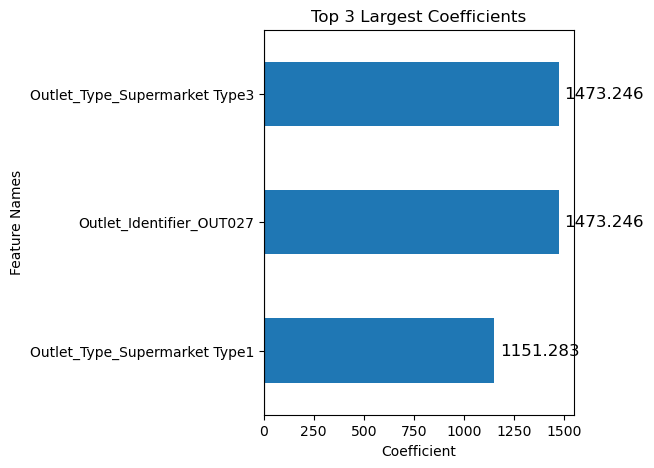

In [45]:
# Plot Top 3 Largest Coefficients
ax = plot_coeffs(coeffs, top_n = 3, intercept = False, annotate = True)

In [46]:
# Save figure
ax.get_figure().savefig('Images/PPS_linreg_top3.png', dpi = 300)

### Interpret Coefficients

#### Coefficients that Positively Influence Final Grade:
* **Outlet_Type_Supermarket Type3**
* > Being in the Outlet_Type_Supermarket Type3 group (being sold from that type of supermarket) increases target by 1,473.25
* **Outlet_Identifier_OUT027**
* > Being in the Outlet_Identifier_OUT027 group (being sold from that particular supermarket) increases target by 1,473.25
* **Outlet_Type_Supermarket Type1**
* > Being in the Outlet_Type_Supermarket Type1 group (being sold from that type of supermarket) increases target by 1,151.28

## Regression Tree Model

The second task is to build a regression tree model to predict sales.

### Build a Regression Tree model

In [47]:
# Instantiate the DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(random_state = 42)

In [48]:
# Fit the data
dec_tree.fit(X_train_df, y_train)

DecisionTreeRegressor(random_state=42)

In [49]:
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.18	RMSE= 1503.34


In [50]:
importances = get_importances(dec_tree, sort=True, ascending=False, name = "Regression Tree Importances")
importances

Item_MRP                          0.44
Outlet_Identifier_OUT027          0.11
Item_Visibility                   0.11
Outlet_Type_Supermarket Type1     0.10
Outlet_Establishment_Year         0.07
Item_Weight                       0.06
Item_Type_Snack Foods             0.01
Outlet_Type_Supermarket Type2     0.01
Outlet_Size                       0.01
Item_Fat_Content_Low Fat          0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Household               0.01
Outlet_Identifier_OUT035          0.01
Outlet_Identifier_OUT049          0.01
Item_Type_Frozen Foods            0.01
Item_Type_Soft Drinks             0.01
Outlet_Identifier_OUT046          0.00
Outlet_Identifier_OUT045          0.00
Item_Type_Dairy                   0.00
Item_Type_Baking Goods            0.00
Item_Type_Starchy Foods           0.00
Item_Type_Canned                  0.00
Item_Type_Hard Drinks             0.00
Item_Type_Breakfast               0.00
Item_Type_Meat                    0.00
Outlet_Location_Type_Tier

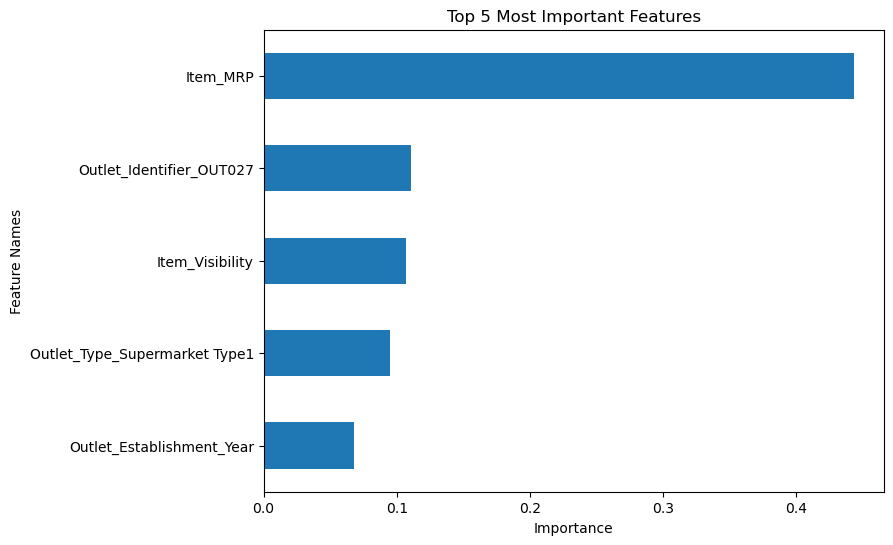

In [51]:
# Plot Top 5 Most Important Features
plot_importance(importances, top_n = 5);

In [52]:
# Save figure
# ax.get_figure().savefig('Images/PPS_dec_tree_top5.png', dpi = 300)

### Interpret Feature Importance

What the feature importance tells us:
* Item_MRP: is the most important feature for predicting 'Item_Outlet_Sales'.
* Outlet_Type_Supermarket Type3: is about four times less important than 'Item_MRP', but is still the second most important feature.
* Item_visibility: is the third-most important feature, but very similar to importance as second place.
* Outlet_Type_Supermarket Type1: is the fourth-most important feature.
* Outlet_Type_Supermarket Type2: is the fifth-most important feature and is about 75% the importance of the second place feature.

### Exploring the Most Important Features

In [53]:
# let's put our DataFrame back together for plotting to include all the train and test values and 
# to ensure our features are matched up with the correct target.

plot_train = pd.concat([X_train_df, y_train], axis=1)
plot_test = pd.concat([X_test_df, y_test], axis = 1)
plot_df = pd.concat([plot_train, plot_test])
plot_df.tail(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
8064,8.10,0.13,210.49,"2,002.00",0.76,1.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,"5,309.76"
4418,6.59,0.03,119.01,"1,999.00",1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,"2,530.71"
1784,15.10,0.03,149.01,"2,007.00",0.76,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,"4,138.61"


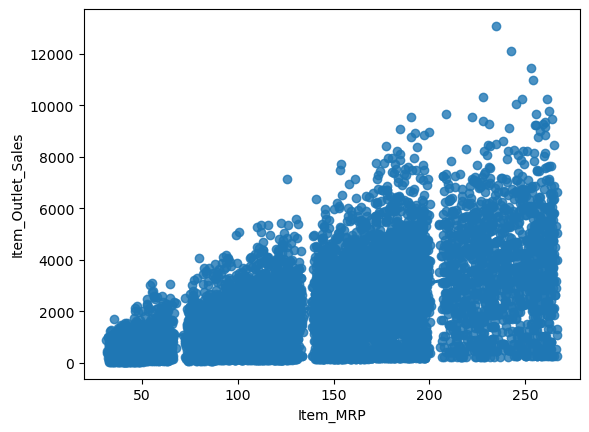

In [54]:
# Visualize top features against the target: 'Item_Outlet_Sales'
sns.regplot(data=plot_df, x='Item_MRP', y='Item_Outlet_Sales');

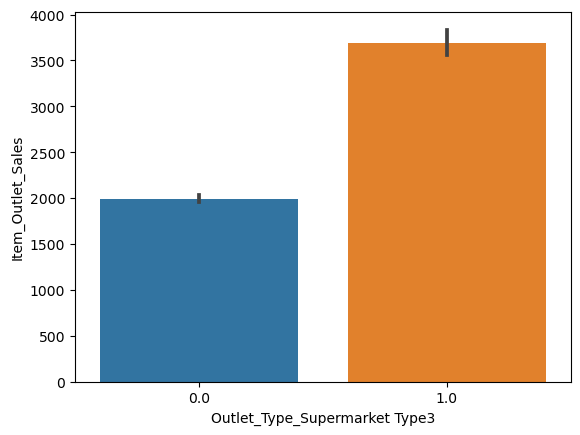

In [55]:
# Visualize top features against the target: 'Item_Outlet_Sales'
sns.barplot(data=plot_df, x='Outlet_Type_Supermarket Type3', y='Item_Outlet_Sales');

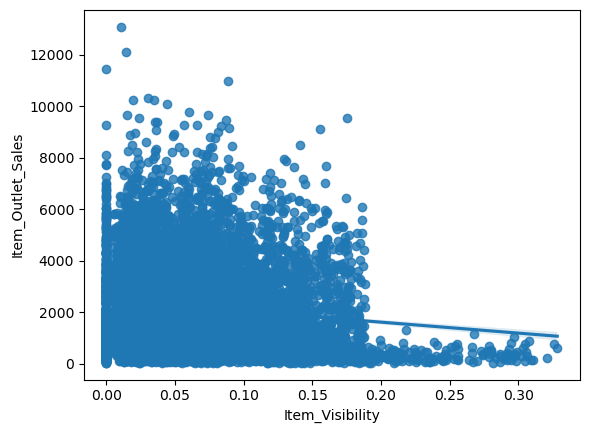

In [56]:
# Visualize top features against the target: 'Item_Outlet_Sales'
sns.regplot(data=plot_df, x='Item_Visibility', y='Item_Outlet_Sales');

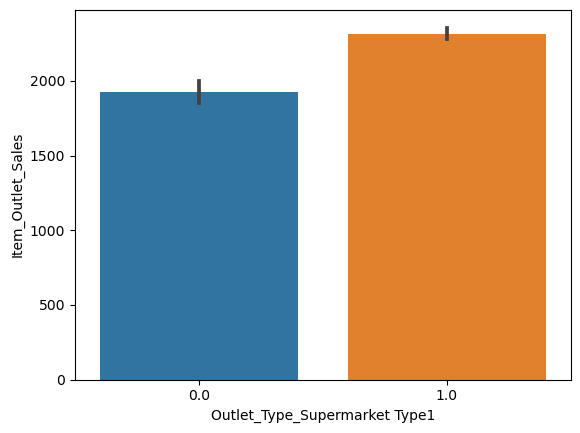

In [57]:
# Visualize top features against the target: 'Item_Outlet_Sales'
sns.barplot(data=plot_df, x='Outlet_Type_Supermarket Type1', y='Item_Outlet_Sales');

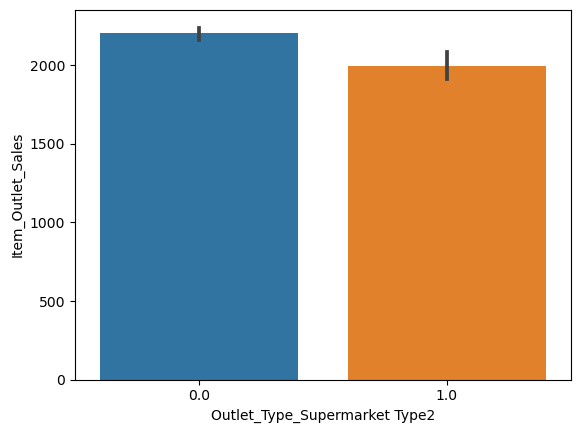

In [58]:
# Visualize top features against the target: 'Item_Outlet_Sales'
sns.barplot(data=plot_df, x='Outlet_Type_Supermarket Type2', y='Item_Outlet_Sales');

## Serialize Models

Serialize best models with Joblib

In [59]:
# Create a dictionary of all variable to save for later
export = {'X_train': X_train_df,
         'y_train': y_train,
         'X_test': X_test_df,
         'y_test': y_test,
         'preprocessor': preprocessor,
         'LinearRegression': linreg,
         'DecisionTreeRegressor': dec_tree}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']